In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("sreeramajay/pollution")
model = AutoModelForImageClassification.from_pretrained("sreeramajay/pollution")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [6]:
from torch.utils.data import Dataset

class WaterQualityDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            'pixel_values': self.images[idx],
            'labels': self.labels[idx]
        }



In [7]:
from PIL import Image
import os
import torch
from torchvision.transforms import functional as F
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split

def load_image(file_path):
    try:
        image = Image.open(file_path)
        image = F.resize(image, (224, 224))
        image = F.center_crop(image, (224, 224))
        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return image
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error loading image {file_path}: {e}")
        return None

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        image = load_image(file_path)
        if image is not None:  # Only append if the image is successfully loaded
            images.append(image)
    if images:
        return torch.stack(images)
    else:
        return torch.empty(0)  # Return an empty tensor if no images are loaded


# Load images
pure_images = load_images_from_folder("/content/drive/MyDrive/Xylem-Data-new/pure")
impure_images = load_images_from_folder("/content/drive/MyDrive/Xylem-Data-new/impure")

# Create the dataset and labels
if len(pure_images) > 0 and len(impure_images) > 0:
    dataset = torch.cat([pure_images, impure_images])
    labels = torch.tensor([0] * len(pure_images) + [1] * len(impure_images))
else:
    dataset = torch.empty(0)
    labels = torch.empty(0)

# Check if dataset and labels are non-empty
if len(dataset) > 0 and len(labels) > 0:
    # Split into train and test sets
    train_images, test_images, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=0.2, random_state=42  # 20% for testing
    )

    # Define the WaterQualityDataset for train and test
    train_dataset = WaterQualityDataset(train_images, train_labels)
    test_dataset = WaterQualityDataset(test_images, test_labels)

    print(f"Training set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
else:
    print("The dataset is empty, please check the image loading.")


Training set: 2252 samples
Test set: 564 samples


In [13]:
from sklearn.metrics import accuracy_score

# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }


In [14]:
# fine-tune model
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    per_device_train_batch_size=2,
    num_train_epochs=2,
    output_dir="./output",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

Step,Training Loss
500,0.037900
1000,0.000300
1500,0.000100
2000,0.000100


TrainOutput(global_step=2252, training_loss=0.008542602679147972, metrics={'train_runtime': 475.8317, 'train_samples_per_second': 9.466, 'train_steps_per_second': 4.733, 'total_flos': 3.4902704941513114e+17, 'train_loss': 0.008542602679147972, 'epoch': 2.0})

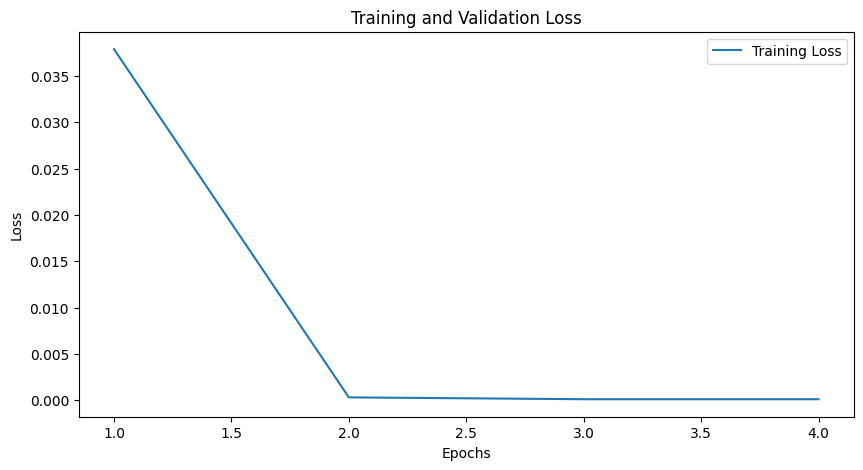

In [15]:
import matplotlib.pyplot as plt

# After trainer.train(), you can access the training logs using the state
history = trainer.state.log_history

# Extract loss and accuracy from the logs
train_loss = [log['loss'] for log in history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
if eval_loss:
    plt.plot(epochs, eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


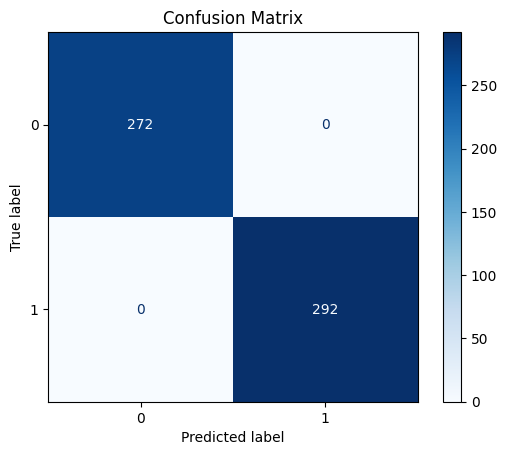

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
predictions = trainer.predict(test_dataset)

# Get the predicted labels (logits -> argmax to get the predicted label)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(true_labels, predicted_labels, target_names=['Pure', 'Impure'])
print(report)


              precision    recall  f1-score   support

        Pure       1.00      1.00      1.00       272
      Impure       1.00      1.00      1.00       292

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564



ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

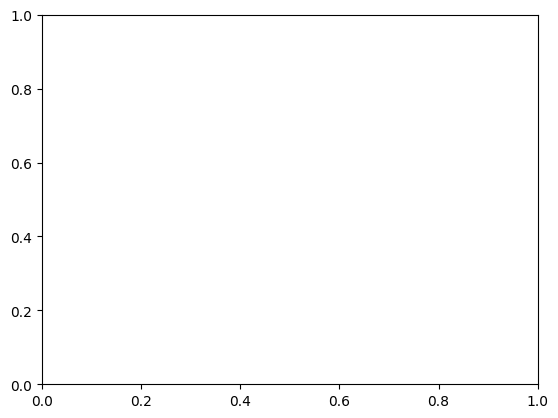

In [18]:
train_acc = [log['accuracy'] for log in history if 'accuracy' in log]
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [19]:
# Check what keys are available in the history
for log in history:
    print(log)


{'loss': 0.0379, 'grad_norm': 0.0026892495807260275, 'learning_rate': 3.889875666074601e-05, 'epoch': 0.44404973357015987, 'step': 500}
{'loss': 0.0003, 'grad_norm': 0.0011407866841182113, 'learning_rate': 2.7797513321492007e-05, 'epoch': 0.8880994671403197, 'step': 1000}
{'loss': 0.0001, 'grad_norm': 0.0007996410713531077, 'learning_rate': 1.669626998223801e-05, 'epoch': 1.3321492007104796, 'step': 1500}
{'loss': 0.0001, 'grad_norm': 0.000684250786434859, 'learning_rate': 5.595026642984015e-06, 'epoch': 1.7761989342806395, 'step': 2000}
{'train_runtime': 475.8317, 'train_samples_per_second': 9.466, 'train_steps_per_second': 4.733, 'total_flos': 3.4902704941513114e+17, 'train_loss': 0.008542602679147972, 'epoch': 2.0, 'step': 2252}
